In [1]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from pathlib import Path
import yfinance as yf

%matplotlib inline

## Data Retreival/Formatting

In [2]:
# Pull data

btc_df = yf.download('BTC-USD')[['Open','High','Low','Volume','Close']]
btc_df.index.name = 'timestamp'

btc_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Volume,Close
timestamp,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,21056800,457.334015
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,34483200,424.440002
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,37919700,394.795990
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,36863600,408.903992
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,26580100,398.821014
...,...,...,...,...,...
2022-10-05 00:00:00+00:00,20335.900391,20343.748047,19801.800781,33223790572,20160.716797
2022-10-06 00:00:00+00:00,20161.039062,20408.392578,19900.087891,34711412966,19955.443359
2022-10-07 00:00:00+00:00,19957.558594,20041.085938,19395.792969,29227315390,19546.849609


In [3]:
# use GET method and connect to API endpoint (Fear and Greed Index API)
r = requests.get('https://api.alternative.me/fng/?limit=0')

In [4]:
# Create fear and greed dataframe

fear_and_greed = pd.DataFrame(r.json()['data'])

fear_and_greed

,value,value_classification,timestamp,time_until_update
0,22,Extreme Fear,1665273600,3086
1,24,Extreme Fear,1665187200,NaN
2,23,Extreme Fear,1665100800,NaN
3,26,Fear,1665014400,NaN
4,25,Extreme Fear,1664928000,NaN
...,...,...,...,...
1704,11,Extreme Fear,1517788800,NaN
1705,24,Extreme Fear,1517702400,NaN
1706,40,Fear,1517616000,NaN
1707,15,Extreme Fear,1517529600,NaN


In [5]:
# convert the value to an integer instead of an object
fear_and_greed['value'] = fear_and_greed.value.astype(int)

# convert timestamp to usable format
fear_and_greed['timestamp'] = pd.to_datetime(fear_and_greed['timestamp'], unit='s', utc=True)

In [6]:
# set index to timsetamp
fear_and_greed = fear_and_greed.set_index('timestamp')

In [7]:
# reorganize data to oldest data points first
fear_and_greed = fear_and_greed[::-1]

fear_and_greed 

,value,value_classification,time_until_update
timestamp,,,
2018-02-01 00:00:00+00:00,30,Fear,NaN
2018-02-02 00:00:00+00:00,15,Extreme Fear,NaN
2018-02-03 00:00:00+00:00,40,Fear,NaN
2018-02-04 00:00:00+00:00,24,Extreme Fear,NaN
2018-02-05 00:00:00+00:00,11,Extreme Fear,NaN
...,...,...,...
2022-10-05 00:00:00+00:00,25,Extreme Fear,NaN
2022-10-06 00:00:00+00:00,26,Fear,NaN
2022-10-07 00:00:00+00:00,23,Extreme Fear,NaN


In [8]:
# Merge btc_df and fear_and_greed
signals_df = fear_and_greed.merge(btc_df, on ='timestamp')

# Drop 'time_until_update' column
signals_df = signals_df.drop(columns='time_until_update')

signals_df

,value,value_classification,Open,High,Low,Volume,Close
timestamp,,,,,,,
2018-02-01 00:00:00+00:00,30,Fear,10237.299805,10288.799805,8812.280273,9959400448,9170.540039
2018-02-02 00:00:00+00:00,15,Extreme Fear,9142.280273,9142.280273,7796.490234,12726899712,8830.750000
2018-02-03 00:00:00+00:00,40,Fear,8852.120117,9430.750000,8251.629883,7263790080,9174.910156
2018-02-04 00:00:00+00:00,24,Extreme Fear,9175.700195,9334.870117,8031.220215,7073549824,8277.009766
2018-02-05 00:00:00+00:00,11,Extreme Fear,8270.540039,8364.839844,6756.680176,9285289984,6955.270020
...,...,...,...,...,...,...,...
2022-10-05 00:00:00+00:00,25,Extreme Fear,20335.900391,20343.748047,19801.800781,33223790572,20160.716797
2022-10-06 00:00:00+00:00,26,Fear,20161.039062,20408.392578,19900.087891,34711412966,19955.443359
2022-10-07 00:00:00+00:00,23,Extreme Fear,19957.558594,20041.085938,19395.792969,29227315390,19546.849609


In [9]:
# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop na
signals_df=signals_df.dropna()

signals_df

,value,value_classification,Open,High,Low,Volume,Close,Actual Returns
timestamp,,,,,,,,
2018-02-02 00:00:00+00:00,15,Extreme Fear,9142.280273,9142.280273,7796.490234,12726899712,8830.750000,-0.037052
2018-02-03 00:00:00+00:00,40,Fear,8852.120117,9430.750000,8251.629883,7263790080,9174.910156,0.038973
2018-02-04 00:00:00+00:00,24,Extreme Fear,9175.700195,9334.870117,8031.220215,7073549824,8277.009766,-0.097865
2018-02-05 00:00:00+00:00,11,Extreme Fear,8270.540039,8364.839844,6756.680176,9285289984,6955.270020,-0.159688
2018-02-06 00:00:00+00:00,8,Extreme Fear,7051.750000,7850.700195,6048.259766,13999800320,7754.000000,0.114838
...,...,...,...,...,...,...,...,...
2022-10-05 00:00:00+00:00,25,Extreme Fear,20335.900391,20343.748047,19801.800781,33223790572,20160.716797,-0.008660
2022-10-06 00:00:00+00:00,26,Fear,20161.039062,20408.392578,19900.087891,34711412966,19955.443359,-0.010182
2022-10-07 00:00:00+00:00,23,Extreme Fear,19957.558594,20041.085938,19395.792969,29227315390,19546.849609,-0.020475


In [10]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 0

signals_df

C:\Users\gtkhh\AppData\Local\Temp\ipykernel_24152\2265619254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df['Signal'] = 0.0


,value,value_classification,Open,High,Low,Volume,Close,Actual Returns,Signal
timestamp,,,,,,,,,
2018-02-02 00:00:00+00:00,15,Extreme Fear,9142.280273,9142.280273,7796.490234,12726899712,8830.750000,-0.037052,0.0
2018-02-03 00:00:00+00:00,40,Fear,8852.120117,9430.750000,8251.629883,7263790080,9174.910156,0.038973,1.0
2018-02-04 00:00:00+00:00,24,Extreme Fear,9175.700195,9334.870117,8031.220215,7073549824,8277.009766,-0.097865,0.0
2018-02-05 00:00:00+00:00,11,Extreme Fear,8270.540039,8364.839844,6756.680176,9285289984,6955.270020,-0.159688,0.0
2018-02-06 00:00:00+00:00,8,Extreme Fear,7051.750000,7850.700195,6048.259766,13999800320,7754.000000,0.114838,1.0
...,...,...,...,...,...,...,...,...,...
2022-10-05 00:00:00+00:00,25,Extreme Fear,20335.900391,20343.748047,19801.800781,33223790572,20160.716797,-0.008660,0.0
2022-10-06 00:00:00+00:00,26,Fear,20161.039062,20408.392578,19900.087891,34711412966,19955.443359,-0.010182,0.0
2022-10-07 00:00:00+00:00,23,Extreme Fear,19957.558594,20041.085938,19395.792969,29227315390,19546.849609,-0.020475,0.0


In [11]:
# Drop Actual Returns
signals_df = signals_df.drop(columns=['Actual Returns','value_classification'])

#Rename value column to fear_and_greed
signals_df = signals_df.rename(columns = {'value':'fear_and_greed'})

signals_df.head()

,fear_and_greed,Open,High,Low,Volume,Close,Signal
timestamp,,,,,,,
2018-02-02 00:00:00+00:00,15,9142.280273,9142.280273,7796.490234,12726899712,8830.750000,0.0
2018-02-03 00:00:00+00:00,40,8852.120117,9430.750000,8251.629883,7263790080,9174.910156,1.0
2018-02-04 00:00:00+00:00,24,9175.700195,9334.870117,8031.220215,7073549824,8277.009766,0.0
2018-02-05 00:00:00+00:00,11,8270.540039,8364.839844,6756.680176,9285289984,6955.270020,0.0
2018-02-06 00:00:00+00:00,8,7051.750000,7850.700195,6048.259766,13999800320,7754.000000,1.0


#### The following code block is necessary for traditional ML, I believe with tensors it may be unnecessary

In [12]:
# # Shift X data to predict the future Y signal value
# signals_df[['open', 'high','low','close','volume', 'trade_count']]=signals_df[['open','high','low','close','volume','trade_count']].shift()
# display(signals_df.head())

# # Drop rows w/ empty values
# signals_df = signals_df.dropna()
# display(signals_df.head())

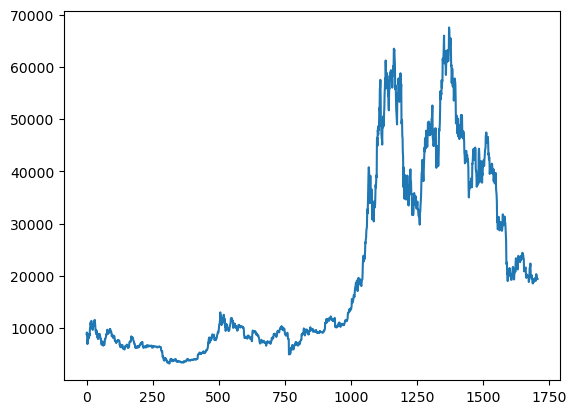

In [13]:
plt.plot(range(len(signals_df)), signals_df[['Close']])

### Splitting data into 3D Tensors

In [14]:
# Split test and train data

split_ratio=.7
train_count=int(len(signals_df)*.7)

train=signals_df.iloc[:train_count]
test=signals_df.iloc[train_count:]

display(train.head())

,fear_and_greed,Open,High,Low,Volume,Close,Signal
timestamp,,,,,,,
2018-02-02 00:00:00+00:00,15,9142.280273,9142.280273,7796.490234,12726899712,8830.750000,0.0
2018-02-03 00:00:00+00:00,40,8852.120117,9430.750000,8251.629883,7263790080,9174.910156,1.0
2018-02-04 00:00:00+00:00,24,9175.700195,9334.870117,8031.220215,7073549824,8277.009766,0.0
2018-02-05 00:00:00+00:00,11,8270.540039,8364.839844,6756.680176,9285289984,6955.270020,0.0
2018-02-06 00:00:00+00:00,8,7051.750000,7850.700195,6048.259766,13999800320,7754.000000,1.0


In [15]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to the features training dataset
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.11111111, 0.09796405, 0.09526091, ..., 0.02816662, 0.09282056,
        0.        ],
       [0.38888889, 0.09315111, 0.0999448 , ..., 0.01247002, 0.09853118,
        1.        ],
       [0.21111111, 0.09851839, 0.09838799, ..., 0.01192343, 0.08363239,
        0.        ],
       ...,
       [0.7       , 0.88705412, 0.8875793 , ..., 0.20770844, 0.76184322,
        0.        ],
       [0.28888889, 0.77129048, 0.78027675, ..., 0.26949871, 0.77122911,
        1.        ],
       [0.23333333, 0.77042043, 0.78201855, ..., 0.15174457, 0.77395605,
        1.        ]])

In [16]:
# Scale test data
test_scaled = scaler.fit_transform(test)

test_scaled

array([[0.26923077, 0.63900422, 0.63447789, ..., 0.40333749, 0.57554297,
        0.        ],
       [0.17948718, 0.57496558, 0.61595764, ..., 0.44672905, 0.56933872,
        0.        ],
       [0.26923077, 0.56882996, 0.55359754, ..., 0.54312062, 0.50980014,
        0.        ],
       ...,
       [0.21794872, 0.02903001, 0.01825306, ..., 0.13754702, 0.02038884,
        0.        ],
       [0.23076923, 0.02064013, 0.00940417, ..., 0.02398178, 0.01773109,
        0.        ],
       [0.20512821, 0.01795449, 0.00819732, ..., 0.02697748, 0.01759761,
        0.        ]])

In [17]:
# Set global candles variable
candles=60

# Create X training set
X_train = []

for i in range(len(train_scaled) - candles):
    X_train.append(train_scaled[:,:5][i:i+candles])

X_train = np.array(X_train)
X_train.shape

(1135, 60, 5)

In [18]:
# Create y training set
y_train = []

for i in range(len(train_scaled) - candles):
    y_train.append(train_scaled[:,6][i+candles])

y_train = np.array(y_train)
y_train.shape

(1135,)

In [19]:
# Create X test set
X_test = []

for i in range(len(test_scaled) - candles):
    X_test.append(test_scaled[:,:5][i  : i+candles])

X_test = np.array(X_test)
X_test.shape

(453, 60, 5)

In [20]:
# Create y test set
y_test = []

for i in range(len(test_scaled) - candles):
    y_test.append(test_scaled[:,6][i+candles])

y_test = np.array(y_test)
y_test.shape

y_test

array([1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1.

## Model Creation

In [21]:
# Check if GPU is working

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
# Create the Sequential model instance
class_nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

#Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = 64

# Define hidden nodes for all hidden layers
hidden_nodes = 64
display(hidden_nodes)

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

#Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

kernelSize=1

64

64

64

In [23]:
# # Add first cnn layer
# class_nn.add(Conv1D(filters=32, kernel_size=kernelSize, padding='same', activation='relu', input_shape=(candles,len(X.columns))))

In [24]:
# #Add second cnn layer
# class_nn.add(Conv1D(filters=64, kernel_size=kernelSize, padding='same'))

In [25]:
# Add the first hidden layer
class_nn.add(Bidirectional(LSTM(units=hidden_nodes, return_sequences=True,input_shape=(candles,(len(signals_df.columns)-2)))))

In [26]:
# # Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [27]:
#Add the second hidden layer
class_nn.add(Bidirectional(LSTM(units=hidden_nodes, return_sequences=True)))


In [28]:
# # Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [29]:
# #Add the third hidden layer
class_nn.add(Bidirectional(LSTM(units=hidden_nodes_layer2, return_sequences=False)))

In [30]:
# Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [31]:
# Add Dense layer
# class_nn.add(Dense(units=6, activation='relu'))

In [32]:
# Add the output layer to the model specifying the number of output neurons and activation function
class_nn.add(Dense(units=1,  activation='sigmoid'))


In [33]:
# Display the Sequential model summary, subclassed model requires build
class_nn.build(X_train.shape)
class_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (1135, 60, 128)          35840     
 l)                                                              
                                                                 
 dropout (Dropout)           (1135, 60, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (1135, 60, 128)          98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (1135, 60, 128)           0         
                                                                 
 bidirectional_2 (Bidirectio  (1135, 128)              98816     
 nal)                                                            
                                                        

In [34]:
# Compile the Sequential model
# class_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy','Precision', 'Recall'))

class_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy'))

In [35]:
# Fit the model using epochs and the training data
class_model = class_nn.fit(X_train, y_train, epochs=100, validation_split=0.1)

Epoch 1/100
32/32 [==============================] - 21s 139ms/step - loss: 0.6918 - accuracy: 0.5348 - val_loss: 0.6928 - val_accuracy: 0.5263
Epoch 2/100
32/32 [==============================] - 1s 45ms/step - loss: 0.6917 - accuracy: 0.5279 - val_loss: 0.6938 - val_accuracy: 0.5439
Epoch 3/100
32/32 [==============================] - 2s 66ms/step - loss: 0.6911 - accuracy: 0.5318 - val_loss: 0.6960 - val_accuracy: 0.5175
Epoch 4/100
32/32 [==============================] - 2s 53ms/step - loss: 0.6902 - accuracy: 0.5348 - val_loss: 0.7145 - val_accuracy: 0.4737
Epoch 5/100
32/32 [==============================] - 2s 47ms/step - loss: 0.6919 - accuracy: 0.5279 - val_loss: 0.7011 - val_accuracy: 0.5175
Epoch 6/100
32/32 [==============================] - 1s 42ms/step - loss: 0.6897 - accuracy: 0.5377 - val_loss: 0.7128 - val_accuracy: 0.5175
Epoch 7/100
32/32 [==============================] - 1s 39ms/step - loss: 0.6901 - accuracy: 0.5328 - val_loss: 0.7172 - val_accuracy: 0.5263
Epoc

In [36]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
# model_loss, model_accuracy, model_precision, model_recall = class_nn.evaluate(X_test, y_test)

model_loss, model_accuracy = class_nn.evaluate(X_test, y_test)

# Display the model loss and accuracy results
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}")

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

15/15 [==============================] - 0s 17ms/step - loss: 0.7275 - accuracy: 0.4834
Loss: 0.7275192737579346, Accuracy: 0.4834437072277069


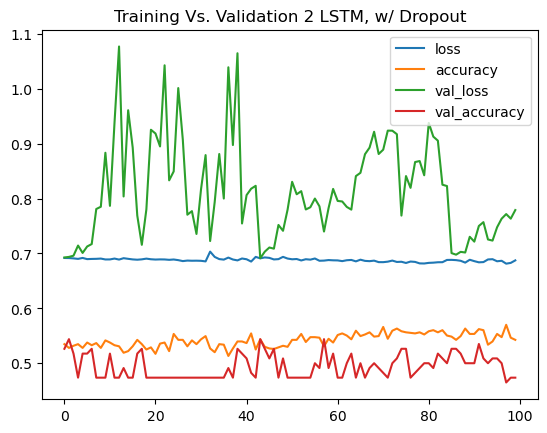

In [37]:
# Train vs test for loss
plt.plot(class_model.history["loss"])
plt.plot(class_model.history["accuracy"])
plt.plot(class_model.history["val_loss"])
plt.plot(class_model.history["val_accuracy"])
plt.title("Training Vs. Validation 2 LSTM, w/ Dropout")
plt.legend(["loss", "accuracy","val_loss","val_accuracy"])
plt.show()

In [38]:
# Set the file path for the first alternative model
file_path = Path('Models/class_class_nn.h5')

# Export your model to a HDF5 file
class_nn.save(file_path)